In [98]:
import pandas as pd
import re
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from enum import Enum
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn import linear_model
from sklearn.metrics import confusion_matrix
import itertools

%matplotlib inline

In [99]:
csvLoc = "D:\\data analytics\\S2\\Ml lab\\dataset\\mbti_1.csv"
df=pd.read_csv(csvLoc)
pd.set_option('display.width', 150)
pd.set_option('display.max_colwidth', 115)
print('shape ',df.shape)
print(df.head())

shape  (8675, 2)
   type                                                                                                               posts
0  INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg|||e...
1  ENTP  'I'm finding the lack of me in these posts very alarming.|||Sex can be boring if it's in the same position ofte...
2  INTP  'Good one  _____   https://www.youtube.com/watch?v=fHiGbolFFGw|||Of course, to which I say I know; that's my bl...
3  INTJ  'Dear INTP,   I enjoyed our conversation the other day.  Esoteric gabbing about the nature of the universe and ...
4  ENTJ  'You're fired.|||That's another silly misconception. That approaching is logically is going to be the key to un...


In [100]:
[p.split('|||') for p in df.head(1).posts.values]

[["'http://www.youtube.com/watch?v=qsXHcwe3krw",
  'http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg',
  'enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks',
  'What has been the most life-changing experience in your life?',
  'http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.',
  'May the PerC Experience immerse you.',
  'The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~   http://vimeo.com/22842206',
  "Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as...",
  '84389  84390  http://wallpaperpassion.com/upload/23700/friendship-boy-and-girl-wallpaper.jpg  http://assets.dornob.com/wp-content/uploads/2010/04

Text(0.5,0,'Types')

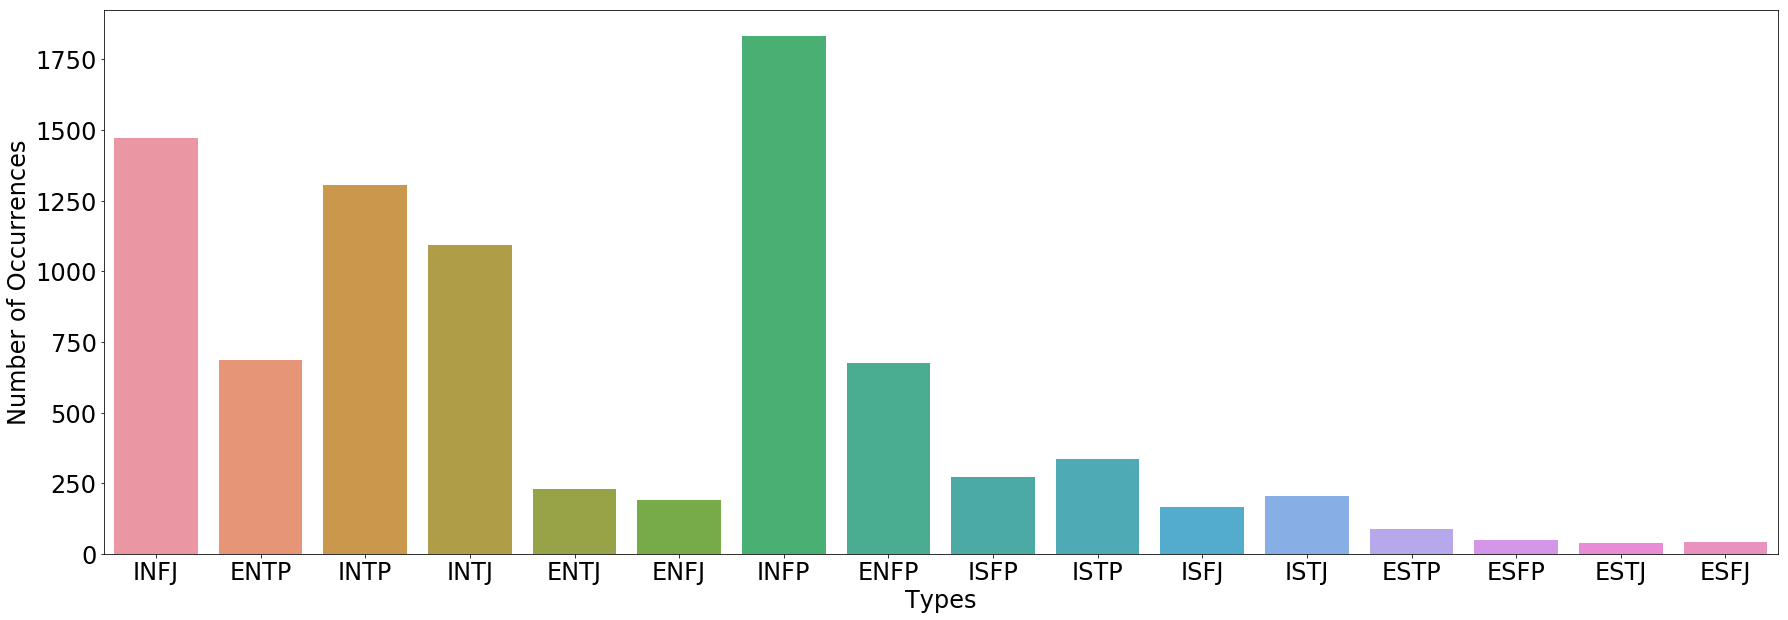

In [101]:
plt.figure(figsize=(30,10))
sns.countplot(data=df, x='type')
plt.xticks(fontsize=24, rotation=0)
plt.yticks(fontsize=24, rotation=0)
plt.ylabel('Number of Occurrences', fontsize=24)
plt.xlabel('Types', fontsize=24)


In [102]:
types=["istj","isfj","infj","intj","istp","isfp","infp","intp","estp","esfp","entp","enfp","estj","esfj","enfj","entj"]
types_re = re.compile("|".join(types))
totalPst=mbtiPost=0
for val in df['posts']:
    posts=val.split("|||")
    totalPst += len(posts)
    for post in posts:
        if types_re.search(post):
            mbtiPost +=1
print("Total posts ",totalPst)
print("mbti posts ",mbtiPost)
print("remaining ",totalPst-mbtiPost)
        


Total posts  422845
mbti posts  5178
remaining  417667


having personality types inside set wouldn't affect result much because number of posts with personality type reference is low.

In [103]:
unique_type_list = ['INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP',
       'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ']
lab_encoder = LabelEncoder().fit(unique_type_list)
print(lab_encoder.classes_)


['ENFJ' 'ENFP' 'ENTJ' 'ENTP' 'ESFJ' 'ESFP' 'ESTJ' 'ESTP' 'INFJ' 'INFP'
 'INTJ' 'INTP' 'ISFJ' 'ISFP' 'ISTJ' 'ISTP']


In [104]:
b_Pers = {'I':0, 'E':1, 'N':0, 'S':1, 'F':0, 'T':1, 'J':0, 'P':1}
b_Pers_list = [{0:'I', 1:'E'}, {0:'N', 1:'S'}, {0:'F', 1:'T'}, {0:'J', 1:'P'}]
Labels=Enum('Labels','MBTI I_E N_S F_T J_P',start=0)
def translate_personality(personality):
    '''
    transform mbti to binary vector
    '''
    return np.array([b_Pers[l] for l in personality])

def translate_back_personality(personality):
    '''
    transform binary vector to mbti personality
    '''
    s = ""
    for i, l in enumerate(personality):
        s += b_Pers_list[i][l]
    return s

   type                posts I_E N_S F_T J_P
0  INFJ  'http://www.yout...   I   N   F   J
1  ENTP  'I'm finding the...   E   N   T   P
2  INTP  'Good one  _____...   I   N   T   P
3  INTJ  'Dear INTP,   I ...   I   N   T   J
4  ENTJ  'You're fired.||...   E   N   T   J


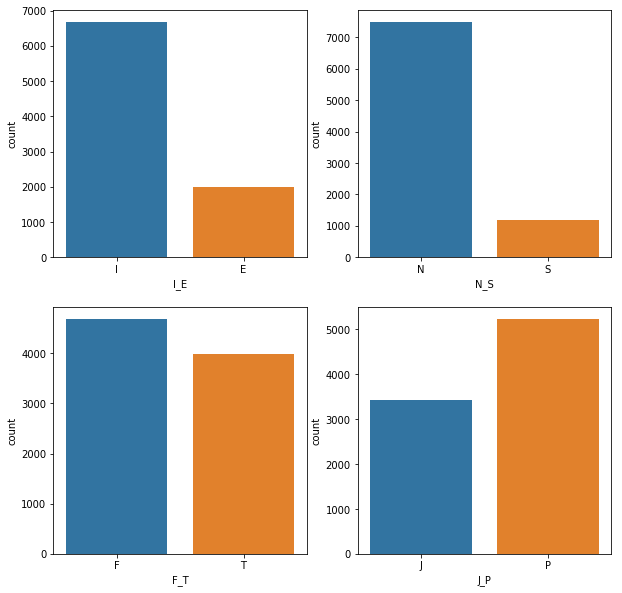

In [105]:
for i in range(1,5):
    name=Labels(i).name
    df[name]=df['type'].map(lambda x:translate_personality(x)[i-1])
    df[name]= df[name].map(lambda x: b_Pers_list[i-1][x] )
pd.set_option('display.max_colwidth', 20)
print(df.head())
f, ax = plt.subplots(2, 2,figsize=(10, 10))
ax=ax.flatten()
for i in range (0,4):
    sns.countplot(data=df,x=Labels(i+1).name,ax=ax[i])



In [106]:
hyperlinkRe = r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))'''
tknzr = TweetTokenizer(preserve_case=False)
vocab = Counter()
wordnet_lemmatizer = WordNetLemmatizer()

#sample preprocessing
post=df['posts'][0]
print("======org=====")
print(post[0:500])

post=re.sub(hyperlinkRe,'', post) #remove hyperlink
print("=======remove hyperlink=====")
print(post[0:500])
#     post=tknzr.tokenize(post)
# #   print("===========tokenize=========")
# #   print(post)
post= re.sub(r'[^a-zA-Z]',' ',post)
post = re.sub(' +', ' ', post).lower()
print("===========spl car remove=========")
print(post[0:500])

post = " ".join([ wordnet_lemmatizer.lemmatize(x) for x in post.split(" ")])
print("===========lemmatize=========")
print(post[0:500])
#     for word in post:
#         vocab[word.lower()]+=1
#     postList[index]=post
# #     print(post)
     

======org=====
'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg|||enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks|||What has been the most life-changing experience in your life?|||http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.|||May the PerC Experience immerse you.|||The last thin
=======remove hyperlink=====
' and intj moments    sportscenter not top ten plays    pranks|||What has been the most life-changing experience in your life?|||     On repeat for most of today.|||May the PerC Experience immerse you.|||The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~    ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. 

In [107]:


def preProcessData(data, remove_stop_words=True):
    cachedStopWords = stopwords.words("english")
    list_personality = []
    list_posts = []
    len_data = len(data)

    for index,row in data.iterrows():
        if index % 500 == 0:
            print("%s | %s rows" % (index, len_data))

        ##### Remove and clean comments
        posts = row['posts']
        temp = re.sub(hyperlinkRe, ' ', posts)
        temp = re.sub("[^a-zA-Z]", " ", temp)
        temp = re.sub(' +', ' ', temp).lower()
        if remove_stop_words:
            temp = " ".join([wordnet_lemmatizer.lemmatize(w) for w in temp.split(' ') if w not in cachedStopWords])
        else:
            temp = " ".join([ wordnet_lemmatizer.lemmatize(x) for x in post.split(" ")])
        list_posts.append(temp)
    list_posts=np.array(list_posts)
    
    #get labels
    list_personality_bin = np.array([translate_personality(p) for p in list(data['type'])])
    list_personality_split=np.transpose(list_personality_bin)
    list_personality_mbti = np.array(lab_encoder.transform(list(data['type'])))
    
    list_personality.append(list_personality_mbti)
    for plist in list_personality_split:
        list_personality.append(plist);
    list_personality=np.array(list_personality)
    print("done!")
    return list_posts, list_personality
    
list_posts, list_personality = preProcessData(df, remove_stop_words=True)   

0 | 8675 rows
500 | 8675 rows
1000 | 8675 rows
1500 | 8675 rows
2000 | 8675 rows
2500 | 8675 rows
3000 | 8675 rows
3500 | 8675 rows
4000 | 8675 rows
4500 | 8675 rows
5000 | 8675 rows
5500 | 8675 rows
6000 | 8675 rows
6500 | 8675 rows
7000 | 8675 rows
7500 | 8675 rows
8000 | 8675 rows
8500 | 8675 rows
done!


In [108]:
print(Labels.MBTI.value)
for i in range(0,5):
    print(lab_encoder.inverse_transform(list_personality[Labels.MBTI.value][i])," ",
          " ".join([b_Pers_list[x][list_personality[x+1][i]] for x in range(0,4)]),
          " ",list_posts[i][0:50])

0
INFJ   I N F J    intj moment sportscenter top ten play prank life 
ENTP   E N T P    finding lack post alarming sex boring position of
INTP   I N T P    good one course say know blessing curse absolutel
INTJ   I N T J    dear intp enjoyed conversation day esoteric gabbi
ENTJ   E N T J    fired another silly misconception approaching log


C:\Users\dell\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\dell\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\dell\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\dell\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in fu

In [109]:
#parameters
termCountLimit =0.9
maxVocab=50000
nsplits=5
regularization_rate=0.005

In [110]:
cntizer = CountVectorizer(max_df=termCountLimit, max_features=maxVocab)                               
tfizer = TfidfTransformer()

X_cnt = cntizer.fit_transform(list_posts)
X_tfidf =  tfizer.fit_transform(X_cnt).toarray()
print("count vectorizer shape")
print(X_cnt.shape)
print("tfidf shape")
print(X_tfidf.shape)

count vectorizer shape
(8675, 50000)
tfidf shape
(8675, 50000)


In [111]:
reverse_dic = {}
for key in cntizer.vocabulary_:
    reverse_dic[cntizer.vocabulary_[key]] = key
top_50 = np.asarray(np.argsort(np.sum(X_cnt, axis=0))[0,-50:][0, ::-1]).flatten()
[reverse_dic[v] for v in top_50]

['feel',
 'type',
 'make',
 'much',
 'well',
 'say',
 'friend',
 'love',
 'way',
 'want',
 'good',
 'see',
 'something',
 'also',
 'lot',
 'go',
 'even',
 'always',
 'life',
 'someone',
 'could',
 'never',
 'though',
 'find',
 'year',
 'thought',
 'need',
 'infp',
 'actually',
 'person',
 'right',
 'work',
 'going',
 'first',
 'sure',
 'yes',
 'infj',
 'pretty',
 'mean',
 'intj',
 'feeling',
 'day',
 'take',
 'come',
 'guy',
 'still',
 'post',
 'thread',
 'look',
 'said']

In [112]:
def plot_confusion_matrix(prediction,actual, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,confText=True,
                          colorBar=True ):
    """
    This function prints and plots the confusion matrix.
    """
    cm = confusion_matrix(actual, prediction)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.imshow(cm, cmap=cmap)
    plt.title(title)
    if(colorBar):
        plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    if confText:
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                plt.text(j, i, format(cm[i, j], fmt),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [120]:

 
# def train_naive_bayes(x,y,name,classes,add_idf=False,confText=True ):
def get_text_vec(x,add_idf=False):
    x = cntizer.transform(x)
    if add_idf == True:
            x_tfidf = tfizer.transform(x)        
            x = np.column_stack((x_tfidf.todense(), x))
    return x

def get_accuracy(preds,act):
    correct=len([x for x in np.subtract(preds,act) if x==0 ]) 
    total=len(act)
    return correct/float(total)

def get_sgd_model():
    return linear_model.SGDClassifier(alpha=regularization_rate)

def get_naivebayes_model():
    return MultinomialNB()
    
def train_model(model,x,y,add_idf=False ):  
    x = get_text_vec(x,add_idf)
    model.fit(x, y)
    train_pred=model.predict(x)
    return model,get_accuracy(train_pred,y)
    

def test_model(model,x_test,y_test,add_idf=False):
    test_pred=model.predict(get_text_vec(x_test,add_idf))
    return test_pred,get_accuracy(test_pred,y_test)





In [121]:
y=list_personality[Labels.MBTI.value]
X_model, X_val, y_model, y_val=train_test_split(list_posts, y,test_size=0.2, stratify=y)

def get_label_distribution(y):
    y=lab_encoder.inverse_transform(y)
    counter=Counter()
    for label in y:
        counter[label] +=1;
    return counter
print("original distribution:")
print(get_label_distribution(y))

print("train set distribution:")
print(get_label_distribution(y_model))

print("test set distribution:")
print(get_label_distribution(y_val))
    

original distribution:
Counter({'INFP': 1832, 'INFJ': 1470, 'INTP': 1304, 'INTJ': 1091, 'ENTP': 685, 'ENFP': 675, 'ISTP': 337, 'ISFP': 271, 'ENTJ': 231, 'ISTJ': 205, 'ENFJ': 190, 'ISFJ': 166, 'ESTP': 89, 'ESFP': 48, 'ESFJ': 42, 'ESTJ': 39})
train set distribution:
Counter({'INFP': 1465, 'INFJ': 1176, 'INTP': 1043, 'INTJ': 873, 'ENTP': 548, 'ENFP': 540, 'ISTP': 270, 'ISFP': 217, 'ENTJ': 185, 'ISTJ': 164, 'ENFJ': 152, 'ISFJ': 133, 'ESTP': 71, 'ESFP': 38, 'ESFJ': 34, 'ESTJ': 31})
test set distribution:
Counter({'INFP': 367, 'INFJ': 294, 'INTP': 261, 'INTJ': 218, 'ENTP': 137, 'ENFP': 135, 'ISTP': 67, 'ISFP': 54, 'ENTJ': 46, 'ISTJ': 41, 'ENFJ': 38, 'ISFJ': 33, 'ESTP': 18, 'ESFP': 10, 'ESTJ': 8, 'ESFJ': 8})


C:\Users\dell\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\dell\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\dell\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


C:\Users\dell\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


I_E
nb train accuracy	=  0.9443804034582133 	nb test accuracy	=  0.8161383285302594
svm train accuracy	=  0.9459654178674352 	svm test accuracy	=  0.8282420749279539
N_S
nb train accuracy	=  0.9531700288184438 	nb test accuracy	=  0.8564841498559078
svm train accuracy	=  0.9701729106628242 	svm test accuracy	=  0.8731988472622478
F_T
nb train accuracy	=  0.9217579250720461 	nb test accuracy	=  0.8115273775216139
svm train accuracy	=  0.936743515850144 	svm test accuracy	=  0.8028818443804034
J_P
nb train accuracy	=  0.9413544668587897 	nb test accuracy	=  0.738328530259366
svm train accuracy	=  0.9085014409221902 	svm test accuracy	=  0.7244956772334294


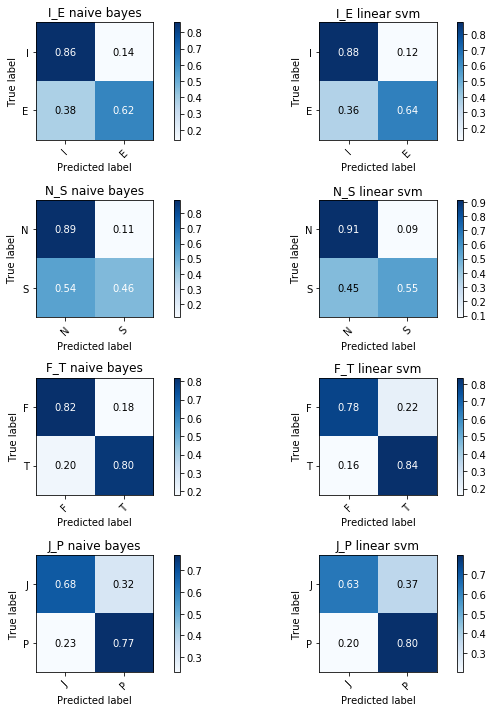

C:\Users\dell\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Single Model
nb train accuracy	=  0.7677233429394813 	 nb test accuracy	=  0.4789625360230548
svm train accuracy	=  0.9590778097982708 	 svm test accuracy	=  0.6023054755043228


C:\Users\dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
C:\Users\dell\Anaconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


Combined Model

nb test accuracy	=  0.715850144092219
svm test accuracy	=  0.7175792507204611


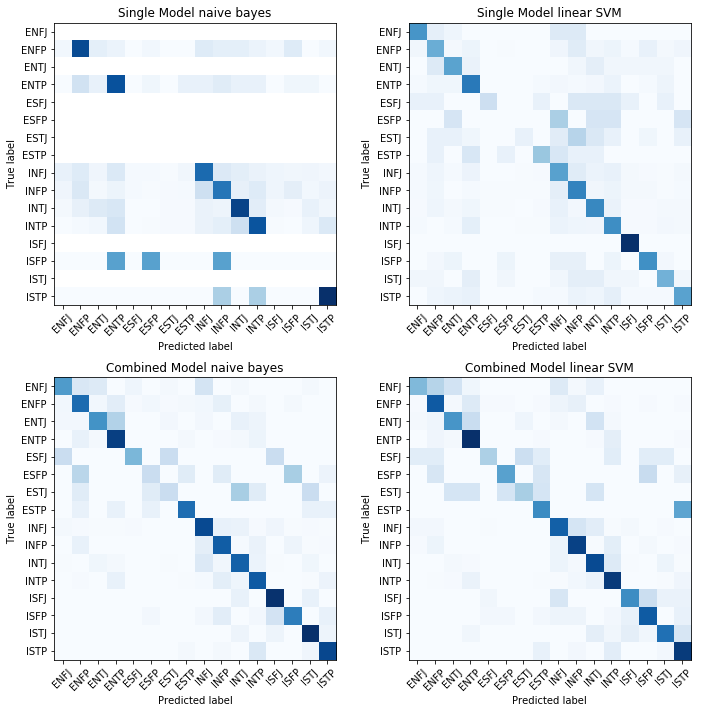

In [126]:

#train and display confusion matrix for seperate models
fig,ax=plt.subplots(4,2,figsize=(10, 10))
ax=ax.flatten()
models=[]
for i in range(1,5):
    label=Labels(i)
    classes=label.name.split("_")
    plt.sca(ax[i-1])
    y=list_personality[label.value]
    name=label.name
    X_model, X_val, y_model, y_val=train_test_split(list_posts, y,test_size=0.2, stratify=y)
    nb_model=get_naivebayes_model()
    svm_model=get_sgd_model()
    nb_model,nb_train_acc=train_model(nb_model,X_model, y_model)
    svm_model,svm_train_acc=train_model(svm_model,X_model, y_model)
    nb_test_pred,nb_test_acc=test_model(nb_model,X_val,y_val)
    svm_test_pred,svm_test_acc=test_model(svm_model,X_val,y_val)
    models.append(nb_model)
    models.append(svm_model)
    print(name)
    plt.sca(ax[2*(i-1)])
    print("nb train accuracy\t= ",nb_train_acc,"\tnb test accuracy\t= ",nb_test_acc)
    print("svm train accuracy\t= ",svm_train_acc,"\tsvm test accuracy\t= ",svm_test_acc)
    plot_confusion_matrix(y_val,nb_test_pred,classes=classes, normalize=True,
                                                title=name+" naive bayes",confText=True)
    plt.sca(ax[2*(i-1)+1])
    plot_confusion_matrix(y_val,svm_test_pred,classes=classes, normalize=True,
                                                title=name+" linear svm",confText=True)
plt.show()


#compare naive bayes in single model vs combined model
fig,ax=plt.subplots(2,2,figsize=(10, 10))
ax=ax.flatten()


y=list_personality[Labels.MBTI.value]
X_model, X_val, y_model, y_val=train_test_split(list_posts, y, test_size=0.2, stratify=y)
classes=lab_encoder.inverse_transform(range(16))

#single model
name="Single Model"
nb_model=get_naivebayes_model()
svm_model=get_sgd_model()
nb_model,nb_train_acc=train_model(nb_model,X_model, y_model)
nb_test_pred,nb_test_acc=test_model(nb_model,X_val,y_val)
svm_model,svm_train_acc=train_model(svm_model,X_model, y_model)
svm_test_pred,svm_test_acc=test_model(svm_model,X_val,y_val)
print(name)
print("nb train accuracy\t= ",nb_train_acc,"\t nb test accuracy\t= ",nb_test_acc)
print("svm train accuracy\t= ",svm_train_acc,"\t svm test accuracy\t= ",svm_test_acc)
plt.sca(ax[0])
plot_confusion_matrix(y_val,nb_test_pred,classes=classes, normalize=True,
                                                title=name+" naive bayes",confText=False,colorBar=False)
plt.sca(ax[1])
plot_confusion_matrix(y_val,svm_test_pred,classes=classes, normalize=True,
                                                title=name+" linear SVM",confText=False,colorBar=False)
def get_combined_pred(single_preds_array):
    ypreds=np.array(single_preds_array)
    ypreds=np.transpose(ypreds)
    ypreds_mbti=[translate_back_personality(x) for x in ypreds]
    final_pred=lab_encoder.transform(ypreds_mbti)
    final_pred=np.array(final_pred)
    return final_pred
#combined model
name="Combined Model"
nb_ypreds=[]
svm_ypreds=[]
validation_vect=get_text_vec(X_val)
for i in range(0,4):
    nb_ypreds.append(np.array(models[2*i].predict(validation_vect)))
    svm_ypreds.append(np.array(models[2*i+1].predict(validation_vect)))
nb_preds=get_combined_pred(nb_ypreds)
svm_preds=get_combined_pred(svm_ypreds)
nb_comb_pred_acc=get_accuracy(nb_preds,y_val)
svm_comb_pred_acc=get_accuracy(svm_preds,y_val)
print(name)
print("\nnb test accuracy\t= ",nb_comb_pred_acc)
print("svm test accuracy\t= ",svm_comb_pred_acc)
plt.sca(ax[2])
plot_confusion_matrix(y_val,nb_preds,classes=classes, normalize=True,
                                                title=name+" naive bayes",confText=False,colorBar=False)
plt.sca(ax[3])
plot_confusion_matrix(y_val,svm_preds,classes=classes, normalize=True,
                                                title=name+" linear SVM",confText=False,colorBar=False)

plt.show()